# Introduction

In this notebook, we move beyond predictive modeling and turn our attention to understanding patterns and relationships within the data through inferential analysis. Specifically, we explore how the presence or absence of certain clinical and behavioral features affects the likelihood of an Alzheimer's diagnosis.

Rather than training a model, our goal here is to derive interpretable, data-driven insights by computing conditional probabilities — such as:

- What is the probability of having Alzheimer’s, given that a patient reports memory complaints?
- How does the risk change if a patient exhibits behavioral problems?

This analysis allows us to:

- Quantify the individual contribution of key symptoms to Alzheimer’s risk,
- Gain transparency into the dataset beyond black-box models,
- Support hypothesis generation and guide clinical focus areas.

By grounding our findings in conditional probability and visual inspection, we aim to enhance interpretability and foster more informed, feature-specific reasoning in the context of Alzheimer’s disease.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

## Loading the dataset

In [7]:
## Reading the traning and testing datasets
df_train = pd.read_csv("../../data/train_set.csv")
df_test = pd.read_csv("../../data/validation_set.csv")

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_test = df_test.drop(columns = ['DoctorInCharge' , 'PatientID' ])

df_train.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,67,0,1,2,29.726811,1,15.642599,4.605988,7.871526,7.915239,...,6.088453,1,0,9.105791,0,0,0,0,0,0
1,76,1,1,2,36.169103,1,11.030414,9.534553,7.254090,4.364895,...,5.399515,1,0,4.725688,0,0,0,0,1,1
2,81,0,1,0,22.923111,0,9.314832,8.917378,3.807813,9.241849,...,4.594907,0,1,8.681801,0,0,0,0,0,1
3,90,0,1,3,31.430904,0,0.996496,7.108725,5.328610,4.977538,...,0.880355,0,0,7.805410,0,0,0,0,0,0
4,89,0,1,3,39.570099,0,1.576700,5.712014,1.026138,4.670244,...,0.293490,0,0,1.307295,0,0,0,0,1,1


In [9]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

## The tuned AdaBoost model

Here, we use the manually recorded tuned parameters from our notebook [Model_Tuning_Entire_Set](https://github.com/mgamankwah/alzheimers_risk_prediction/blob/main/scripts/3-Model%20Tuning/1_Model_Tuning_Entire_Set_Seyed.ipynb).

In [14]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 2,
    'min_samples_split': 19
}
model_tuned_ada_params = {
    'n_estimators': 130,
    'learning_rate': 0.26971280658002783,
    'algorithm': 'SAMME.R'
}

# Tuned AdaBoost model for the entire dataset
model_tuned_entire_dataset = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)

model_tuned_entire_dataset.fit(df_train[all_features[:-1]], df_train.Diagnosis)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=2,
                                                    min_samples_split=19,
                                                    random_state=123),
                   learning_rate=0.26971280658002783, n_estimators=130,
                   random_state=123)

## Isotonic-Calibrated Probabilistic Model

In [19]:
# Isotonic calibration pipeline
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_tuned_entire_dataset, method='isotonic', cv=5)
calibrated_model_isotonic.fit(df_train[all_features[:-1]], df_train.Diagnosis)

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123),
                       method='isotonic')

In [21]:
# Predict calibrated probabilities on the test set
calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk'] = calibrated_probs_isotonic
df_test[['Diagnosis', 'alzheimers_risk']].head()

,Diagnosis,alzheimers_risk
0,0,0.066837
1,1,0.711071
2,1,0.884134
3,0,0.035592
4,0,0.120600


In [23]:
def assign_risk_group(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

In [25]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk', 'risk_group']].head()

,Diagnosis,alzheimers_risk,risk_group
0,0,0.066837,Low
1,1,0.711071,High
2,1,0.884134,High
3,0,0.035592,Low
4,0,0.120600,Low


# Analysis of Effect of Important Features

We saw that cognitive features and assessment scores like `MMSE`, `FunctionalAssessment`, `ADL`, `MemoryComplaints`, `BehavioralProblems` and the clinical measurement `CholesterolHDL` were the top 6 ranked features when feature importance analysis was performed.

In [28]:
important_features = ['MMSE', 'FunctionalAssessment', 'ADL', 
                      'MemoryComplaints', 'BehavioralProblems', 'CholesterolHDL']

Of these, `MemoryComplaints` and `BehavioralProblems` are binary features.

## Binary Features

In [31]:
# Using empirical proportions (frequencies) of actual diagnosis outcomes within each group of the binary feature

binary_features = ['MemoryComplaints', 'BehavioralProblems']

for feature in binary_features:
    print(f"\n--- Conditional Alzheimer’s Probability: {feature} ---")
    display(pd.crosstab(df_test[feature], df_test['Diagnosis'], normalize='index').round(3))


--- Conditional Alzheimer’s Probability: MemoryComplaints ---


Diagnosis,0,1
MemoryComplaints,,
0,0.715,0.285
1,0.386,0.614



--- Conditional Alzheimer’s Probability: BehavioralProblems ---


Diagnosis,0,1
BehavioralProblems,,
0,0.702,0.298
1,0.364,0.636


**Interpretation:** The above tables show $P(\text{Diagnosis}|\text{Feature})$.

- Patients who report memory complaints have more than double the Alzheimer’s risk (61.4%) compared to those who don’t (28.5%). This aligns strongly with clinical expectations — memory complaints are often one of the earliest red flags.

- Presence of behavioral problems also more than doubles the probability of Alzheimer's diagnosis (63.6% vs 29.8%) — likely pointing to the neuropsychiatric aspects of the disease.

Both features are strong conditional indicators of Alzheimer’s, possibly useful for early screening.

In [33]:
# Using calibrated risk of Alzheimer's

for feature in binary_features:
    print(f"\n--- Average Calibrated Risk by {feature} ---")
    display(df_test.groupby(feature)['alzheimers_risk'].mean().round(3))


--- Average Calibrated Risk by MemoryComplaints ---


MemoryComplaints
0    0.295
1    0.572
Name: alzheimers_risk, dtype: float64


--- Average Calibrated Risk by BehavioralProblems ---


BehavioralProblems
0    0.307
1    0.586
Name: alzheimers_risk, dtype: float64

**Interpretation:** The above tables show $\mathbb{E}[\text{Modeled Risk of Alzheimer's}|\text{Feature}]$.

- Our calibrated model gives an expected Alzheimer's risk of 59.9% for patients who report memory complaints, which is again about twice as compared to those who don’t (28.1%). 

- Similarly, our model expects an Alzheimer's risk of 57.5% for patients who exhibit behavioral problems, which is again about twice as compared to those who don’t (30.2%). 

The results are very close to the ones observed using frequentist proportions. This shows that our calibrated model is well-aligned with the empirical truth, which is desirable in medical contexts like Alzheimer's prediction.

**Conclusion:**

- Our model is thus capturing the clinical signal from binary symptoms well.

## Continuous Features

We bin continuous predictors into Low, Medium and High value groups.

In [63]:
# Define binned columns
binned_features = {
    'MMSE': 'MMSE_bin',
    'FunctionalAssessment': 'FA_bin',
    'ADL': 'ADL_bin',
    'CholesterolHDL': 'Cholesterol_bin'
}

# Create quantile-based bins
df_test['MMSE_bin'] = pd.qcut(df_test['MMSE'], q=3, labels=['Low', 'Medium', 'High'])
df_test['FA_bin'] = pd.qcut(df_test['FunctionalAssessment'], q=3, labels=['Low', 'Medium', 'High'])
df_test['ADL_bin'] = pd.qcut(df_test['ADL'], q=3, labels=['Low', 'Medium', 'High'])
df_test['Cholesterol_bin'] = pd.qcut(df_test['CholesterolHDL'], q=3, labels=['Low', 'Medium', 'High'])

# Loop through features and show both empirical and model-based risk
for feature, bin_col in binned_features.items():
    print(f"\n📊 {feature} — Empirical vs Calibrated Risk")
    
    # Empirical: observed diagnosis proportion (Diagnosis = 1)
    empirical = pd.crosstab(df_test[bin_col], df_test['Diagnosis'], normalize='index')[1].rename('Empirical')
    
    # Model-based: mean predicted risk
    model = df_test.groupby(bin_col, observed=True)['alzheimers_risk'].mean().rename('Model')

    comparison = pd.concat([empirical, model], axis=1).round(3)
    display(comparison)


📊 MMSE — Empirical vs Calibrated Risk


,Empirical,Model
MMSE_bin,,
Low,0.417,0.389
Medium,0.447,0.439
High,0.191,0.226



📊 FunctionalAssessment — Empirical vs Calibrated Risk


,Empirical,Model
FA_bin,,
Low,0.557,0.548
Medium,0.368,0.373
High,0.130,0.133



📊 ADL — Empirical vs Calibrated Risk


,Empirical,Model
ADL_bin,,
Low,0.591,0.588
Medium,0.289,0.278
High,0.174,0.188



📊 CholesterolHDL — Empirical vs Calibrated Risk


,Empirical,Model
Cholesterol_bin,,
Low,0.313,0.329
Medium,0.395,0.386
High,0.348,0.340


**Interpretation for the effect of MMSE (Mini-Mental State Examination) on Alzheimer's risk:**

- Patients in the High MMSE group (i.e., higher cognitive function) have the lowest Alzheimer’s risk both empirically and by the model — as expected.
- The Medium group has slightly higher risk than the Low group, which may suggest:
- Some non-linear effects (e.g., mild cognitive impairment doesn’t always progress to AD).

**Interpretation for the effect of Functional Assessment on Alzheimer's risk:**

- Strong, clear decreasing trend — lower FA (i.e., more impairment) → higher Alzheimer’s risk.
- The model is extremely well-calibrated here. It not only matches the pattern, but also the exact risk levels almost perfectly.
- Suggests FA is a robust and reliable predictor in our model and in real-world patient data.

**Interpretation for the effect of ADL (Activities of Daily Living) on Alzheimer's risk:**

- Again, a clear inverse relationship — more difficulty with daily tasks (lower ADL score) → higher risk of Alzheimer’s.
- Model risk aligns nearly identically with empirical risk.
- Confirms that functional independence is a strong marker of cognitive decline in this population.

**Interpretation for the effect of Cholesterol (HDL) on Alzheimer's risk:**

- Unlike MMSE, FA, or ADL, this doesn’t show a strong monotonic trend.
- Medium HDL levels are associated with the highest Alzheimer’s risk, both empirically and in model predictions, not very insightful biologically.
- The model captures the general shape of the trend, though with slightly less separation between bins than in the empirical data.

This is not surprising, as CholesterolHDL was the least important feature among the features we considered.

## Compare averages of features across risk groups

In [70]:
df_test.groupby('risk_group')[['MMSE', 'FunctionalAssessment', 'ADL']].mean().round(2)

,MMSE,FunctionalAssessment,ADL
risk_group,,,
High,11.15,3.16,3.40
Low,15.69,5.96,5.96
Medium,16.22,6.19,3.72


In [72]:
df_test.groupby('risk_group')[['MemoryComplaints', 'BehavioralProblems']].mean().round(2)

,MemoryComplaints,BehavioralProblems
risk_group,,
High,0.38,0.26
Low,0.12,0.09
Medium,0.27,0.64


# Summary Plot of Risk vs Important Features

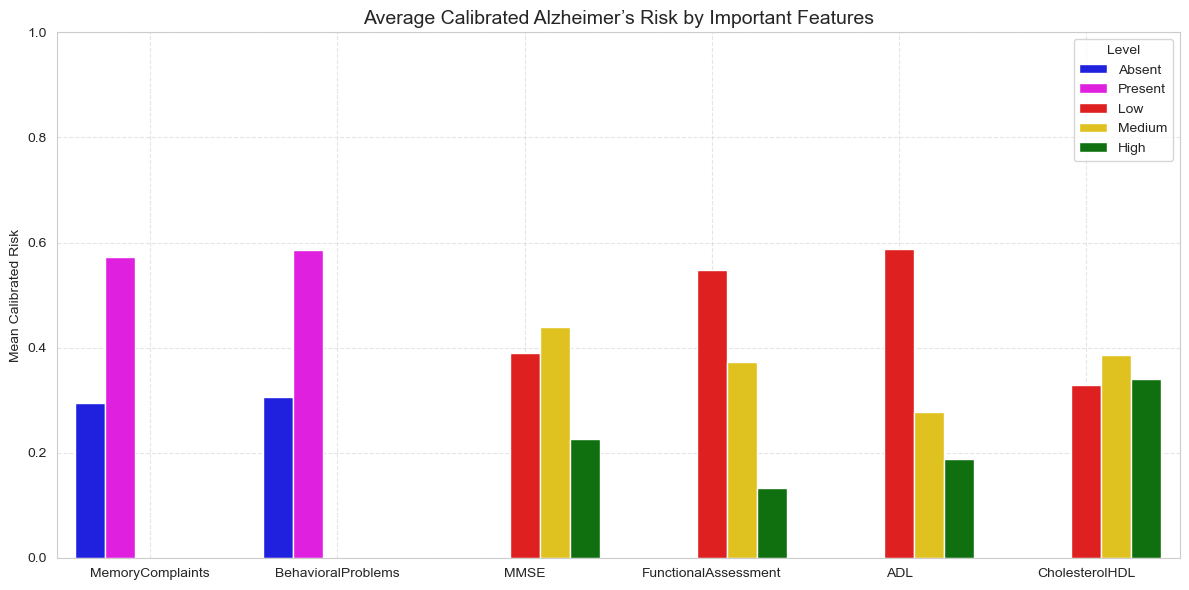

In [57]:
plot_data = []

# Binary features
binary_features = ['MemoryComplaints', 'BehavioralProblems']
for feature in binary_features:
    for level in df_test[feature].unique():
        avg_risk = df_test[df_test[feature] == level]['alzheimers_risk'].mean()
        plot_data.append({
            'Feature': feature,
            'Level': level,
            'MeanRisk': avg_risk
        })

# Binned continuous features
binned_features = {
    'MMSE': 'MMSE_bin',
    'FunctionalAssessment': 'FA_bin',
    'ADL': 'ADL_bin',
    'CholesterolHDL': 'Cholesterol_bin'
}

for feature, bin_col in binned_features.items():
    for level in df_test[bin_col].cat.categories:
        avg_risk = df_test[df_test[bin_col] == level]['alzheimers_risk'].mean()
        plot_data.append({
            'Feature': feature,
            'Level': level,
            'MeanRisk': avg_risk
        })
plot_df = pd.DataFrame(plot_data)
plot_df['Level'] = plot_df['Level'].replace({
    0: 'Absent',
    1: 'Present'
})

custom_palette = {
    'Absent': 'blue',
    'Present': 'magenta',
    'Low': 'red',
    'Medium': 'gold',
    'High': 'green'
}

plt.figure(figsize=(12, 6))

sns.barplot(
    data=plot_df,
    x='Feature',        
    y='MeanRisk',       
    hue='Level',       
    palette=custom_palette,
    dodge=True
)

plt.title("Average Calibrated Alzheimer’s Risk by Important Features", fontsize=14)
plt.ylabel("Mean Calibrated Risk")
plt.xlabel("")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

# Conclusion

- Presence of memory complaint and behavioral problems is associated with higher risk of Alzheimer’s.
- Higher MMSE, Functional Assessment and ADL scores are associated with lower risk of Alzheimer’s.
- This is expected as lower scores on cognitive assessments indicate greater impairment.